In [11]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical


## Data Loading and Processing

In [12]:
labels = pd.read_csv("table_withlabels.csv")
foof = pd.read_csv("foof2features.csv")
beh = pd.read_csv("behaviorals.csv")

In [13]:
foof['IDs'] = foof['C1']
df = pd.merge(foof, labels[['label', 'IDs']], on='IDs', how='inner')
df = df.drop(columns=['C1'])
print(df['label'].value_counts())
df

Other Neurodevelopmental Disorders    492
ADHD-Inattentive Type                 388
ADHD-Combined Type                    376
Anxiety Disorders                     241
No Diagnosis Given                    203
Depressive Disorders                   85
Name: label, dtype: int64


,C2,C3,IDs,label
0,0.986272,1.825774,NDARAA075AMK,No Diagnosis Given
1,1.486650,1.888544,NDARAA112DMH,ADHD-Combined Type
2,1.593155,2.095749,NDARAA117NEJ,ADHD-Combined Type
3,0.703331,1.724831,NDARAA947ZG5,ADHD-Combined Type
4,0.918020,1.749441,NDARAA948VFH,ADHD-Combined Type
...,...,...,...,...
1780,0.168009,0.205704,NDARZN148PMN,Anxiety Disorders
1781,1.351549,1.996940,NDARZN277NR6,ADHD-Combined Type
1782,0.339229,1.050644,NDARZN610GTY,Other Neurodevelopmental Disorders
1783,0.781225,1.470061,NDARZN677EYE,ADHD-Inattentive Type


In [14]:
# add labels
pd.options.mode.chained_assignment = None

df.label[df.label == 'Other Neurodevelopmental Disorders'] = 1
df.label[df.label == 'ADHD-Inattentive Type'] = 2
df.label[df.label == 'ADHD-Combined Type'] = 3
df.label[df.label == 'Anxiety Disorders'] = 4
df.label[df.label == 'No Diagnosis Given'] = 5
df.label[df.label == 'Depressive Disorders'] = 6
df.label = df['label'].astype(int)
labels = ['Other Neurodevelopmental Disorders', 'ADHD-Inattentive Type', 'ADHD-Combined Type', 'Anxiety Disorders', 'No Diagnosis Given', 'Depressive Disorders']

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_labels, test_labels = train_df['label'], test_df['label']
train_df.shape
print(test_labels.shape)
print(train_labels.shape)
train_features = train_df[train_df.columns.difference(['IDs', 'label'])]
test_features = test_df[test_df.columns.difference(['IDs', 'label'])]
print(test_features.shape)
print(train_features.shape)

(357,)
(1428,)
(357, 2)
(1428, 2)


## Dealing with imbalance

In [16]:
oversample = SMOTE()
train_features_oversampled, train_labels_oversampled = oversample.fit_resample(train_features, train_labels)
print(train_features_oversampled.shape)
print(train_labels_oversampled.shape)

(2358, 2)
(2358,)


In [17]:
# scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_oversampled = scaler.fit_transform(train_features_oversampled) 
test_features = scaler.transform(test_features)

train_features_oversampled = np.clip(train_features_oversampled, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [18]:
print(train_features_oversampled.shape)
print(train_labels_oversampled.shape)

(2358, 2)
(2358,)


## Linear Models

### SVC

In [19]:
from sklearn import svm

clf = svm.SVC(kernel='linear', verbose=True)
clf.fit(train_features_oversampled, train_labels_oversampled)

predicted_labels_svc = clf.predict(test_features)

[LibSVM].
*
optimization finished, #iter = 1064
obj = -764.757894, rho = -0.318171
nSV = 766, nBSV = 763
.
*
optimization finished, #iter = 800
obj = -748.510563, rho = 0.089375
nSV = 750, nBSV = 747
.*.
*
optimization finished, #iter = 1082
obj = -756.619599, rho = -0.344603
nSV = 758, nBSV = 755
.*
optimization finished, #iter = 807
obj = -769.667648, rho = 0.088493
nSV = 771, nBSV = 768
.
*
optimization finished, #iter = 1094
obj = -571.634381, rho = -0.231712
nSV = 573, nBSV = 570
.*..*
optimization finished, #iter = 2548
obj = -719.063116, rho = 0.017901
nSV = 721, nBSV = 718
*
optimization finished, #iter = 710
obj = -778.381956, rho = -0.508254
nSV = 781, nBSV = 778
.*
optimization finished, #iter = 1213
obj = -749.257330, rho = 0.137952
nSV = 751, nBSV = 748
*.
*
optimization finished, #iter = 787
obj = -603.268772, rho = -0.282554
nSV = 605, nBSV = 602
.
*
optimization finished, #iter = 1389
obj = -709.049509, rho = -0.096258
nSV = 710, nBSV = 707
.
*.
*.
*
optimization finish

Accuracy: 0.19327731092436976
Precision: 0.13677592249020817
Recall: 0.20420887598102788
F1 score: 0.1004234178108142


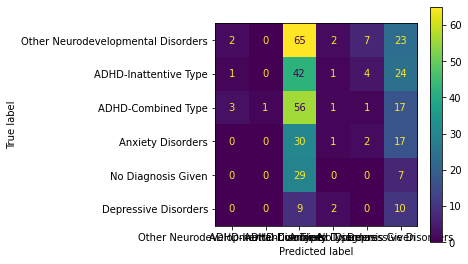

In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred, show_cm=True):
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
#     print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred, multi_class='ovo',))
    print("F1 score:", metrics.f1_score(y_test, y_pred, average='macro'))
#     print("Brier Score:", metrics.brier_score_loss(y_test, y_pred)) # only for binary classification

    if show_cm:
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.tight_layout()
        plt.show()

evaluate(test_labels, predicted_labels_svc)

### OneVsRestClassifier
The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=2000, verbose=True))

clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_ovr = clf.predict(test_features)

[LibLinear].................................................................................
optimization finished, #iter = 815
Objective value = -1305.184744
nSV = 2358
[LibLinear]...........................................................................
optimization finished, #iter = 756
Objective value = -1309.884736
nSV = 2358
[LibLinear]................................................................................*
optimization finished, #iter = 808
Objective value = -1281.651344
nSV = 2319
[LibLinear]...................................................................
optimization finished, #iter = 673
Objective value = -1308.776387
nSV = 2358
[LibLinear]...................................................*......................................*
optimization finished, #iter = 898
Objective value = -1298.597450
nSV = 2355
[LibLinear]..............................................................................***
optimization finished, #iter = 789
Objective value = -1179.442554
n

Accuracy: 0.19607843137254902
Precision: 0.27597206181598194
Recall: 0.21753876924763002
F1 score: 0.11478696191964383


/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


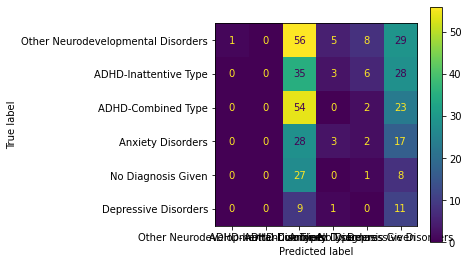

In [22]:
evaluate(test_labels, predicted_labels_ovr)

### OneVsOneClassifier
OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. In the event of a tie (among two classes with an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.



In [23]:
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(LinearSVC(random_state=0, max_iter = 10000, verbose=True))

clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_ovo = clf.predict(test_features)

[LibLinear].............................................................................
optimization finished, #iter = 773
Objective value = -782.697225
nSV = 786
[LibLinear]............................................................................*...............................................................................
optimization finished, #iter = 1557
Objective value = -776.848836
nSV = 786
[LibLinear].............................................................................
optimization finished, #iter = 773
Objective value = -780.258380
nSV = 786
[LibLinear].......................................................................
optimization finished, #iter = 717
Objective value = -782.694567
nSV = 786
[LibLinear].................................................................................*............................*.*
optimization finished, #iter = 1106
Objective value = -672.763317
nSV = 760
[LibLinear]..........................................................

Accuracy: 0.19607843137254902
Precision: 0.27597206181598194
Recall: 0.21753876924763002
F1 score: 0.11478696191964383


/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


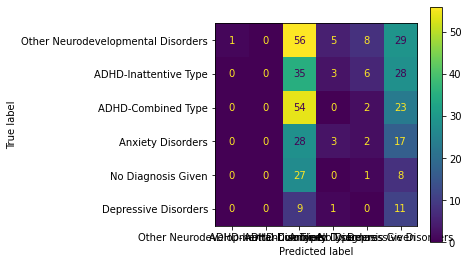

In [24]:
evaluate(test_labels, predicted_labels_ovr)

### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0, verbose=True)
clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_rf = clf.predict(test_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 0.16246498599439776
Precision: 0.17122092234804961
Recall: 0.1932864966725726
F1 score: 0.1433041367409147


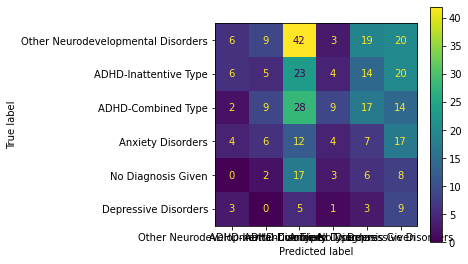

In [26]:
evaluate(test_labels, predicted_labels_rf)

### MLP


In [27]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300, verbose=True)
clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_mlp = clf.predict(test_features)

Iteration 1, loss = 1.79944915
Iteration 2, loss = 1.76496501
Iteration 3, loss = 1.74730261
Iteration 4, loss = 1.73994130
Iteration 5, loss = 1.73663292
Iteration 6, loss = 1.73383378
Iteration 7, loss = 1.73211852
Iteration 8, loss = 1.73087096
Iteration 9, loss = 1.72962374
Iteration 10, loss = 1.72884331
Iteration 11, loss = 1.72787630
Iteration 12, loss = 1.72709608
Iteration 13, loss = 1.72631943
Iteration 14, loss = 1.72548808
Iteration 15, loss = 1.72485169
Iteration 16, loss = 1.72406063
Iteration 17, loss = 1.72352066
Iteration 18, loss = 1.72323467
Iteration 19, loss = 1.72254845
Iteration 20, loss = 1.72195739
Iteration 21, loss = 1.72134483
Iteration 22, loss = 1.72075357
Iteration 23, loss = 1.72018581
Iteration 24, loss = 1.72011151
Iteration 25, loss = 1.71939656
Iteration 26, loss = 1.71872957
Iteration 27, loss = 1.71863932
Iteration 28, loss = 1.71803147
Iteration 29, loss = 1.71782374
Iteration 30, loss = 1.71719103
Iteration 31, loss = 1.71666668
Iteration 32, los

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.1568627450980392
Precision: 0.16797251124094537
Recall: 0.22221520509495188
F1 score: 0.14809848234755082


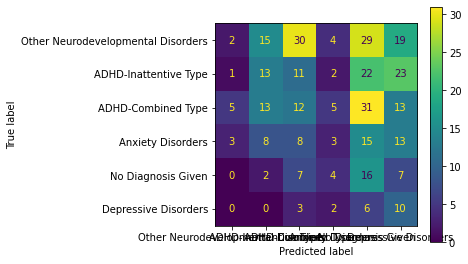

In [28]:
evaluate(test_labels, predicted_labels_mlp)